# CS445: Term Project

#### Victor Weeks & Josh Lutz

Note: I think I am going to explore changing my idea to taking current inventory info and deciding how best to make a profit

## Introduction

In [2]:
from gw2spidy import Gw2Spidy as spidy # allows retrieval of market information
import numpy as np
import json
import random
import neuralnetworksA4 as nn
import matplotlib.pyplot as plt
%matplotlib inline

### Data

In [3]:
itemIDs = (19718,19720,19697,19680,19719,19738,19723,19710,
           19739,19740,19699,19683,19703,19687,19728,19733,19726,19713,
           19741,19742,19698,19682,19730,19734,19727,19714,
           19743,19744,19702,19686,19731,19736,19736,19724,19711,
           19748,19747,19700,19684,19729,19735,19722,19709,
           19745,19746,19701,19685,19732,19737,19725,19712)

In [4]:
from datetime import datetime

In [27]:
itemTimeData = np.load('itemData.npy')
itemTimeData.shape

(10302, 13)

In [28]:
names = ['item_id', 'max_offer_price', 'min_sale_price', 'offer_availability', 'sale_availability', 'sale_price_change', 'offer_price_change', 'year', 'month', 'day', 'hour', 'minute', 'second']

In [29]:
def makeItemData(itemID=19718, allItems=False, splitData=False, stepsAheadToPredict=4):
    itemTimeData = np.load('itemData.npy')
    if allItems:
        itemData = np.mean(itemTimeData[0:50], axis=0).reshape((1,-1))
        for bucket in itemTimeData[51::51]:
            itemData = np.vstack((itemData, np.mean(bucket.reshape((1,-1)), axis=0).reshape((1,-1))))
    else:
        itemData = itemTimeData[np.where(itemTimeData[:]==itemID)[0]]
    X = itemData[:-stepsAheadToPredict, 1:7].copy()
    T = itemData[stepsAheadToPredict:, 1:2].copy()
    if splitData:
        rows = np.arange(X.shape[0])
        nTrain = int(X.shape[0] * 0.7)
        Xtrain = X[rows[:nTrain],:]
        Ttrain = T[rows[:nTrain],:]
        Xtest = X[rows[nTrain:],:]
        Ttest = T[rows[nTrain:],:]
        return Xtrain, Ttrain, Xtest, Ttest
    else:        
        return X, T, itemData

Note: Had to make sure to copy the X and T data because of how the Time-Embedded data is accessed.

In [30]:
Xtrain, Ttrain, items = makeItemData(allItems=True) # training with all items
Xtest, Ttest, item1 = makeItemData(19735)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((198, 6), (198, 1), (198, 6), (198, 1))

In [31]:
Xtrain, Ttrain, Xtest, Ttest = makeItemData(19743, allItems=True, splitData=True) #Train and test with all items
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((138, 6), (138, 1), (60, 6), (60, 1))

In [34]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

In [72]:
import pandas as pd
def getBestAvgNeuralStructure(Xtrain,Xtest,Ttrain,Ttest,nIterations=1000,timesToAvg=5,plot=False):
    errors = []
    for hids in hiddens:
        errorTrain = 0
        errorTest = 0
        errorAvg = 0
        for _ in range(timesToAvg):
            nnet = nn.NeuralNetwork(Xtrain.shape[1], hids, Ttrain.shape[1])
            nnet.train(Xtrain, Ttrain, nIterations)
            errorTrain += rmse(Ttrain, nnet.use(Xtrain))
            errorTest += rmse(Ttest, nnet.use(Xtest))
            errorAvg = (errorTrain + errorTest)/2
        errors.append([hids,errorTrain/timesToAvg,errorTest/timesToAvg,errorAvg/timesToAvg])
    errors = pd.DataFrame(errors)
    print(errors)
    if plot==True:
        plt.figure(figsize=(10, 10))
        plt.plot(errors.values[:, 1:], 'o-')
        plt.title('RMSE Values for Neural Net')
        plt.legend(('Train', 'Test', 'Avg Error'))
        plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
        plt.grid(True)
    minErrorAverage = errors[3].min()
    minIndex = list(errors[3]).index(minErrorAverage)
    bestHids = errors[0][minIndex]
    print('Lowest average error over',timesToAvg,'fully trained iterations:',bestHids,'with error:',minErrorAverage)
    return bestHids

                       0         1         2         3
0                      0  1.429377  0.761946  1.095662
1                    [1]  1.481404  0.789779  1.135592
2                 [1, 1]  1.571617  1.000154  1.285885
3              [1, 1, 1]  1.576359  0.966634  1.271497
4           [1, 1, 1, 1]  1.583915  0.975007  1.279461
5        [1, 1, 1, 1, 1]  1.593949  0.907186  1.250568
6                    [5]  1.421664  0.828404  1.125034
7                 [5, 5]  1.554480  0.909564  1.232022
8              [5, 5, 5]  1.576041  0.997180  1.286611
9           [5, 5, 5, 5]  1.576860  0.981208  1.279034
10       [5, 5, 5, 5, 5]  1.580608  0.968615  1.274612
11                  [10]  1.408775  0.783036  1.095905
12              [10, 10]  1.509570  0.897664  1.203617
13          [10, 10, 10]  1.568186  0.902814  1.235500
14      [10, 10, 10, 10]  1.565448  1.007466  1.286457
15  [10, 10, 10, 10, 10]  1.579986  0.981686  1.280836
16                  [20]  1.377265  0.767139  1.072202
17        

[50]

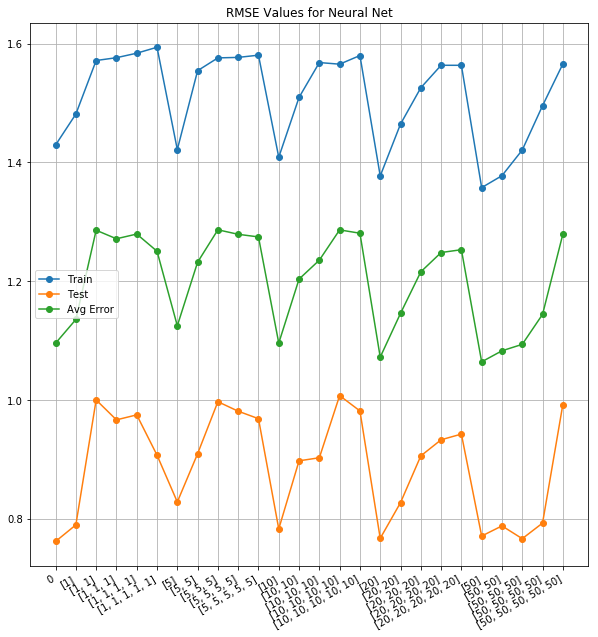

In [74]:
getBestAvgNeuralStructure(XtrainW,XtestW,TtrainW,TtestW,1,5,True)

#### Time-Embedding

In [12]:
def rollingWindows(X, windowSize):    
    nSamples, nAttributes = X.shape
    nWindows = nSamples - windowSize + 1
    # Shape of resulting matrix
    newShape = (nWindows, nAttributes * windowSize)
    itemSize = X.itemsize  # number of bytes
    # Number of bytes to increment to starting element in each dimension
    strides = (nAttributes * itemSize, itemSize)
    return np.lib.stride_tricks.as_strided(X, shape=newShape, strides=strides)

In [13]:
XtrainW = rollingWindows(Xtrain, 2)
TtrainW = rollingWindows(Ttrain, 2)
XtestW = rollingWindows(Xtest, 2)
TtestW = rollingWindows(Ttest, 2)
XtrainW.shape, TtrainW.shape, XtestW.shape, TtestW.shape

((137, 12), (137, 2), (59, 12), (59, 2))

In [14]:
Xtrain[0:2]

array([[  3.18580000e+02,   3.58220000e+02,   5.57863420e+05,
          1.63556236e+06,   0.00000000e+00,   0.00000000e+00],
       [  7.70000000e+01,   9.20000000e+01,   6.64614000e+05,
          4.51649000e+05,   0.00000000e+00,   0.00000000e+00]])

In [15]:
XtrainW[0]

array([  3.18580000e+02,   3.58220000e+02,   5.57863420e+05,
         1.63556236e+06,   0.00000000e+00,   0.00000000e+00,
         7.70000000e+01,   9.20000000e+01,   6.64614000e+05,
         4.51649000e+05,   0.00000000e+00,   0.00000000e+00])

In [16]:
nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10,10], Ttrain.shape[1])
nnet.train(Xtrain, Ttrain, 1000, verbose=True)

SCG: Iteration 100 fValue Eval 0.257318363333 Scale 1e-15
SCG: Iteration 200 fValue Eval 0.223812384722 Scale 1e-15
SCG: Iteration 300 fValue Eval 0.176662433645 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.156707204184 Scale 1e-15
SCG: Iteration 500 fValue Eval 0.154519192839 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.152376183021 Scale 1e-15
SCG: Iteration 700 fValue Eval 0.15033338351 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.147998688858 Scale 1e-15
SCG: Iteration 900 fValue Eval 0.144842837622 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.140550498069 Scale 1e-15


NeuralNetwork(6, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 1.1886 seconds. Final error is 0.37490065093186237.

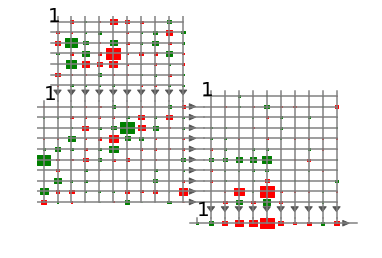

In [17]:
nnet.draw()

NeuralNetwork(6, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 1.1886 seconds. Final error is 0.37490065093186237.


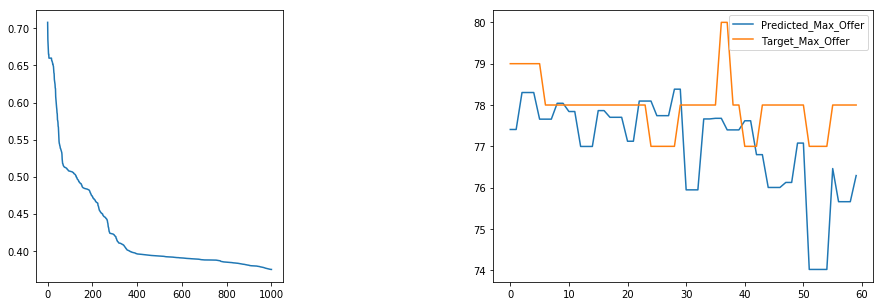

In [18]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(nnet.getErrors())
print(nnet)

Y = nnet.use(Xtest)
plt.subplot(1,2,2)
plt.plot(Y, label='Predicted_Max_Offer')
plt.plot(Ttest, label='Target_Max_Offer')
plt.legend();

In [19]:
keepTrain = [ len(np.unique(Trow))==1 for Trow in TtrainW ]
keepTest = [ len(np.unique(Trow))==1 for Trow in TtestW ]
sum(keepTrain)

116

In [20]:
XtrainW = XtrainW[keepTrain, :]
TtrainW = TtrainW[keepTrain, :]
TtrainW = TtrainW[:, 0:1] # reduce to single class label

XtestW = XtestW[keepTest, :]
TtestW = TtestW[keepTest, :]
TtestW = TtestW[:, 0:1] # reduce to single class label

In [21]:
nnet = nn.NeuralNetwork(XtrainW.shape[1], [10,10,10], TtrainW.shape[1])
nnet.train(XtrainW/(XtrainW.max(axis=0)), TtrainW/(TtrainW.max(axis=0)), 1000, verbose=True)

SCG: Iteration 100 fValue Eval 0.0689566428167 Scale 1e-15
SCG: Iteration 200 fValue Eval 0.0337889637952 Scale 1e-15
SCG: Iteration 300 fValue Eval 0.0259649331972 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.0219462078174 Scale 1e-15
SCG: Iteration 500 fValue Eval 0.0108556535825 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.00350756001693 Scale 1e-15
SCG: Iteration 700 fValue Eval 0.00221208157337 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.00174119483695 Scale 1e-15
SCG: Iteration 900 fValue Eval 0.00119739510318 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.000994592085493 Scale 1e-15


NeuralNetwork(12, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 1.1720 seconds. Final error is 0.03153715404871833.

NeuralNetwork(12, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 1.1720 seconds. Final error is 0.03153715404871833.


C:\Users\Pooka\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Pooka\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


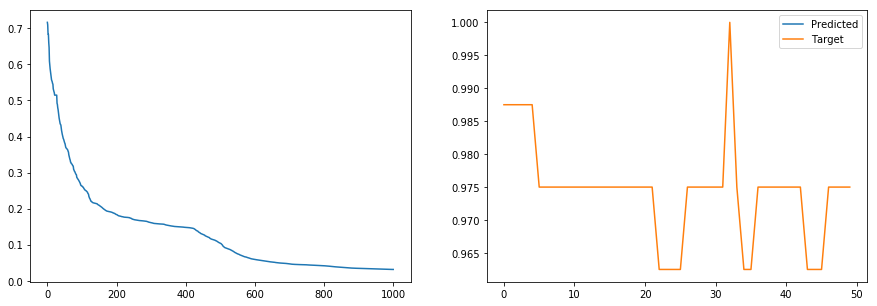

In [22]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(nnet.getErrors())
print(nnet)

Y = nnet.use(XtestW/(XtestW.max(axis=0)))
plt.subplot(1,2,2)
plt.plot(Y, label='Predicted')
plt.plot(TtestW/(TtestW.max(axis=0)), label='Target')
plt.legend();

#### Recurrent Neural Network

In [ ]:
X[0:2]

In [ ]:
plt.figure(figsize=(15,15))
nrow, ncol = item1.shape
for c in range(ncol):
    plt.subplot(4, 4, c+1)
    plt.plot(item1[:, c])
    plt.tight_layout()

In [ ]:
Tnames = names[1:2]
Xnames = names[1:]

In [ ]:
def plotItemData(Tplot=0):
    plt.figure(figsize=(10,10))
    for c in range(X.shape[1]):           
        plt.subplot(3, 2, c+1)
        plt.plot(X[:, c], T[:, Tplot], 'o', alpha=0.5)
        plt.ylabel(Tnames[Tplot])
        plt.xlabel(Xnames[c])
        plt.tight_layout()

In [ ]:
plotItemData(Tplot=0)

In [ ]:
plotItemData(Tplot=1)

In [ ]:
plotItemData(Tplot=2)

In [ ]:
plotItemData(Tplot=3)

In [ ]:
plotItemData(Tplot=4)

In [ ]:
plotItemData(Tplot=5)

In [ ]:
def train(X, T, nUnits=3, nIterations=2000, learningRate=0.01, W=None):
    
    nSamples, nInputs = X.shape
    nTargets = T.shape[1]

    if W is None:
        W = np.random.uniform(-1, 1, (1+nInputs+nUnits, nUnits)) / np.sqrt(1+nInputs+nUnits)

    Y = np.zeros((nSamples, nUnits))
    P = np.zeros((1+nInputs+nUnits, nUnits, nUnits))
    Z = np.zeros((1+nInputs+nUnits, 1))
    Z[0,:] = 1
    delta = np.zeros((nUnits, 1))
    dW = np.zeros_like(W)

    errors = np.zeros(nIterations)
    errors[:] = np.nan
    Ws = np.zeros((nIterations, (1+nInputs+nUnits)*nUnits))
    Ws[:] = np.nan

    fig = plt.figure(figsize=(10, 15))

    for iteration in range(nIterations):
        Y[:] = 0
        P[:] = 0
        dW[:] = 0
        errSum = 0
        Z[1+nInputs:] = 0
        for n in range(nSamples):
            # if n % 10 == 0:
            #     P[:] = 0
            Z[1:1+nInputs] = X[n, :]
            Y[n, :] = np.tanh(Z.T @ W)
            delta[:nTargets, :] = 2 * (Y[n, :nTargets] - T[n, :])
            dW += np.squeeze(P @ delta)
            Z[1+nInputs:,0] = Y[n, :]
            PW = P @ W[1+nInputs:, :]
            PW[:, range(nUnits), range(nUnits)] += Z
            P = (1 - Y[n, :]**2) * PW
            errSum += (Y[n,:nTargets] - T[n,:])**2
            W = W - learningRate * dW / nSamples
        
        errors[iteration] = np.sqrt(errSum/nSamples)
        Ws[iteration, :] = W.flat
       
        if iteration % ((nIterations+1)//20) == 0:
            fig.clf()
            plt.subplot(4, 1, 1)
            plt.plot(errors)
            plt.xlim(0, nIterations)
            # plt.ylim(0, 0.3)
            plt.xlabel('Iteration')
            plt.ylabel('RMS Error')
            
            plt.subplot(4, 1, 2)
            # plt.plot(X, label='Input')
            plt.plot(T, label='Target')
            plt.plot(Y[:,:nTargets], label='Trained Unit 0')
            plt.legend()
            
            plt.subplot(4, 1, 3)
            plt.plot(Y)
            plt.ylabel('All Unit Outputs')
            labels = ['Trained Unit 0']
            for u in range(1,nUnits):
                labels += ['Unit {}'.format(u)]
            plt.legend(labels)
            
            plt.subplot(4, 1, 4)
            plt.plot(Ws)
            plt.xlim(0, nIterations)
            plt.xlabel('Iteration')
            plt.ylabel('Weights')
            labels = []
            for u in range(nUnits):
                labels += ['{} bias'.format(u), '{} input'.format(u), '{} recurrent'.format(u)]
            plt.legend(labels)

            clear_output(wait=True)
            display(fig);
    
    clear_output(wait=True)
    return W

In [ ]:
from IPython.display import display, clear_output

In [ ]:
W = train(X, T, nUnits=4, nIterations=1000, learningRate=0.01)

In [ ]:
def run(X, T, hiddenUnits, nIterations=100, verbose=False):
    if X.shape[1] != 1 or T.shape[1] != 1:
        print('This function written for one-dimensional input samples, X, and one-dimensional targets, T.')
        return
    
    nnet = nn.NeuralNetwork(1, hiddenUnits,1 )

    nnet.train(X, T, nIterations=nIterations, verbose=verbose)
    # print("SCG stopped after",nnet.getNumberOfIterations(),"iterations:",nnet.reason)
    Y = nnet.use(X)
    Ytest, Ztest = nnet.use(Xtest, allOutputs=True)
    print('Training took {:.4f} seconds.'.format(nnet.getTrainingTime()))
    print("Final RMSE: train", np.sqrt(np.mean((Y-T)**2)), "test", np.sqrt(np.mean((Ytest-Ttest)**2)))

    plt.figure(figsize=(10, 15))
    nHLayers = len(nnet.nhs)
    nPlotRows = 3 + nHLayers

    plt.subplot(nPlotRows, 1, 1)
    plt.plot(nnet.getErrors())
    plt.title('Regression Example')

    plt.subplot(nPlotRows, 1, 2)
    plt.plot(X, T, 'o-', label='Training Data')
    plt.plot(X, Y, 'o-', label='Train NN Output')
    plt.ylabel('Training Data')
    plt.legend(loc='lower right', prop={'size':9})

    plt.subplot(nPlotRows, 1, 3)
    plt.plot(Xtest, Ttest, 'o-', label='Test Target')
    plt.plot(Xtest, Ytest, 'o-', label='Test NN Output')
    plt.ylabel('Testing Data')
    plt.xlim(0, 10)
    plt.legend(loc='lower right', prop={'size':9})
    for i in range(nHLayers):
        layer = nHLayers-i-1
        plt.subplot(nPlotRows, 1, i+4)
        plt.plot(Xtest, Ztest[layer])
        plt.xlim(0, 10)
        plt.ylim(-1.1, 1.1)
        plt.ylabel('Hidden Units')
        plt.text(8, 0, 'Layer {}'.format(layer+1))
    return nnet

In [ ]:
def run(X, T, hiddenUnits, nIterations=100, verbose=False, saveWeightsHistory=False):
    if X.shape[1] != 1 or T.shape[1] != 1:
        print('This function written for one-dimensional input samples, X, and one-dimensional targets, T.')
        return
    nnet = nn.NeuralNetwork(1, hiddenUnits,1 )
    nnet.train(X, T, nIterations=nIterations, verbose=verbose, saveWeightsHistory=saveWeightsHistory)
    return nnet

In [ ]:
nnet = run(X, T, [50], nIterations=1000, verbose=True)
nnet

In [ ]:
nnet = run(X, T, [20, 5, 3], nIterations=1000, verbose=True, saveWeightsHistory=True)
nnet

In [ ]:
from matplotlib import animation
import matplotlib # for next statement
matplotlib.rc('animation', html='html5')

In [ ]:
weightsHistory = nnet.getWeightsHistory()
nnet._unpack(weightsHistory[0,:])
Y = nnet.use(X)
Ytest, Ztest = nnet.use(Xtest, allOutputs=True)

nHLayers = len(nnet.nhs)
nPlotRows = 3 + nHLayers

fig = plt.figure(figsize=(10, 15))
plt.subplot(nPlotRows, 1, 1)
errors = nnet.getErrors()
errorsLine = plt.plot(0,errors[0])[0]
plt.xlim(0,len(errors))
plt.ylim(0,np.max(errors)*1.1)

plt.title('Regression Example')

plt.subplot(nPlotRows, 1, 2)
plt.plot(X, T, 'o-', label='Training Data')
trainLine = plt.plot(X, Y, 'o-', label='Train NN Output')[0]
plt.ylabel('Training Data')
plt.legend(loc='lower right', prop={'size':9})

plt.subplot(nPlotRows, 1, 3)
plt.plot(Xtest, Ttest, 'o-', label='Test Target')
testLine = plt.plot(Xtest, Ytest, 'o-', label='Test NN Output')[0]
plt.ylabel('Testing Data')
plt.xlim(0, 10)
plt.legend(loc='lower right', prop={'size':9})
hiddenOutputLines = []
for i in range(nHLayers):
    layer = nHLayers-i-1
    plt.subplot(nPlotRows, 1, i+4)
    hiddenOutputLines.append( plt.plot(Xtest, Ztest[layer]) )
    plt.xlim(0, 10)
    plt.ylim(-1.1, 1.1)
    plt.ylabel('Hidden Units')
    plt.text(8, 0, 'Layer {}'.format(layer+1))
    
updatesPerFrame = 2

def animator(framei):
    step = framei * updatesPerFrame
    nnet._unpack(weightsHistory[step,:])
    Y = nnet.use(X)
    Ytest, Ztest = nnet.use(Xtest, allOutputs=True)
    errorsLine.set_data(range(step),errors[:step])
    trainLine.set_ydata(Y)
    testLine.set_ydata(Ytest)
    
    for iLayer in range(len(hiddenOutputLines)):
        HOLines = hiddenOutputLines[iLayer]
        Zlayer = Ztest[nHLayers - iLayer - 1]
        for iUnit in range(len(HOLines)):
            HOLines[iUnit].set_ydata(Zlayer[:,iUnit])
    return [errorsLine, trainLine, testLine] + hiddenOutputLines

## Methods

Notes: 
* could seperate all items into train and test data
* could train on one item, test on another

In [ ]:
# This method acts as the reinforcement and accounts for the 15% handling cost for selling items on the market
def checkForProfit(price_sold, price_bought):
    profit = (price_sold - (price_sold * 0.15)) - price_bought
    if profit > 0:
        return 1
    elif profit < 0:
        return -1
    else:
        return 0

## Results

## Conclusions

## References